In [13]:
import numpy as np
import time
from matplotlib.pyplot import *

In [2]:
%load_ext fortranmagic #Fortran magic command - pip install fortran-magic

In [3]:
%%fortran
subroutine geo(delay_now,&
               W_geometric,&
               ha,&
               loc,&
               dec,&
               len1)
        !declaring variables
        !Remeber intent out is variables that are sent out of the
        !subroutine..


        
        integer(kind=4), intent(in)                 :: len1
        real(kind=8), intent(in)                    :: dec
        real(kind=8), intent(in),dimension(3)       :: loc
        real(kind=8), intent(out), dimension(len1)               :: delay_now
        real(kind=8), intent(out), dimension(len1)               :: W_geometric
        real(kind=8), intent(in), dimension(len1)                :: ha
        integer(kind=4)                    :: i
        REAL(kind=8), DIMENSION(2027520) :: X, Y, Z
        REAL(kind=8)               :: c_per_mus = 299.792458, pi = 3.14159265359
        do i = 1, len1
                X(i)            = (loc(1)*cos(dec*pi/180))/c_per_mus
                Y(i)            = (-1.0*loc(2)*cos(dec*pi/180))/c_per_mus
                Z(i)            = (loc(3)*sin(dec*pi/180))/c_per_mus
                W_geometric(i)  = (X(i)*cos(ha(i)*pi/180) +Y(i)*sin(ha(i)*pi/180) + Z(i))
                delay_now(i)    = X(i)*cos(ha(i)*pi/180) +Y(i)*sin(ha(i)*pi/180)
        enddo
        !return

end subroutine


In [4]:
def get_delay(ha,
              loc,
              dec):
    """Example function for f2py
       
    """
    #Defining constants..
    c_per_mus   = 299.792458
    pi          = 3.14159265359
    deg2rad     = pi/180.0
    X           = np.zeros((len(ha)))
    Y           = np.zeros((len(ha)))
    Z           = np.zeros((len(ha)))
    W_geometric = np.zeros((len(ha)))
    delay_now   = np.zeros((len(ha)))

    for i in range(len(ha)):
        X[i]            = (loc[0] * np.cos(dec*deg2rad)) / c_per_mus
        Y[i]            = (-1.0*loc[1]*np.cos(dec*deg2rad)) / c_per_mus
        Z[i]            = (loc[2]*np.sin(dec*deg2rad))/c_per_mus
        W_geometric[i]  = (X[i]*np.cos(ha[i]*deg2rad) +Y[i]*np.sin(ha[i]*deg2rad) + Z[i])
        delay_now[i]    = X[i]*np.cos(ha[i]*deg2rad)  +Y[i]*np.sin(ha[i]*deg2rad)
    return delay_now, W_geometric


In [5]:
#defing ha and loc for benchmarking 
ha  = np.linspace(-12, 12, 10000)
loc = np.array([10, 20, 100])

# Benchmarking fortran and pure (sort of) python 

In [6]:
%timeit get_delay(ha, loc, 100)

174 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%timeit geo(ha, loc, 100)

231 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
print(f'First level improvement of ~{183e-3/233e-6}')

First level improvement of ~785.4077253218884


# How does the improvement scale?

In [32]:
#For pure python
python_time  = np.zeros((100))
fortran_time = np.zeros((100))

#Declaring loc 
loc = np.array([10, 20, 100])


    
for i in range(100):
    ha  = np.linspace(-12, 12, 1000*i)
    start_time = time.time()
    get_delay(ha, loc, 100)
    python_time[i] = time.time() - start_time

In [33]:
#For fortran

for i in range(100):
    ha  = np.linspace(-12, 12, 1000*i)
    start_time = time.time()
    geo(ha, loc, 100)
    fortran_time[i] = time.time() - start_time

In [34]:
style.use('F2PY_Example_Reference/matplotlib_rc_jpy')
%matplotlib notebook

<IPython.core.display.Javascript object>


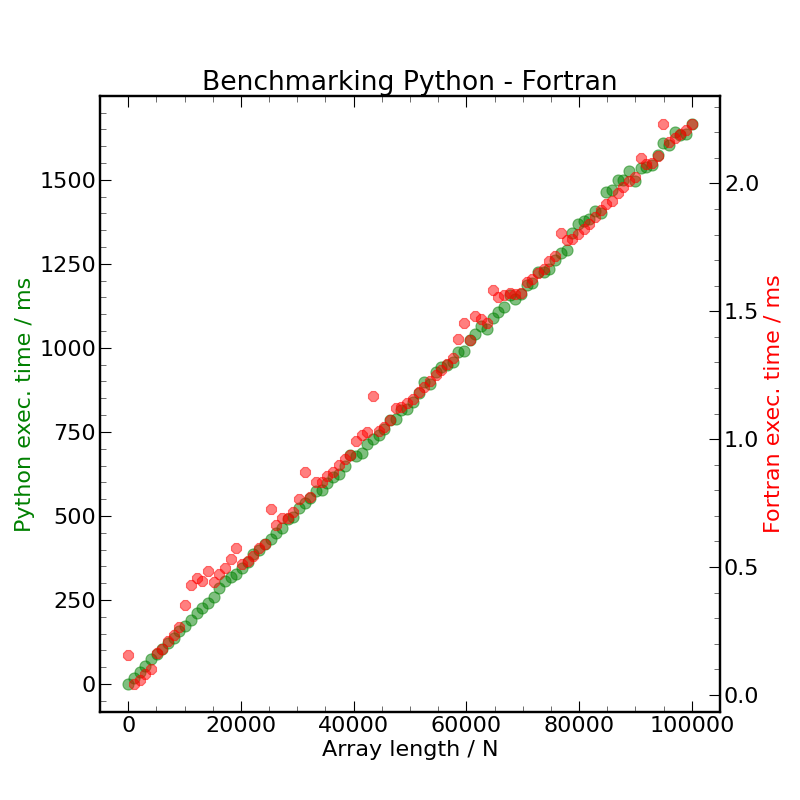

Text(0.5, 0, 'Array length / N')

In [59]:
fig, ax = subplots()
ax.set_title('Benchmarking Python - Fortran')
ax.plot(np.linspace(0, 100*1000, 100),
     python_time*1e3,
     'go',
     alpha = 0.5
)

ax1 = ax.twinx()
ax1.plot(np.linspace(0, 100*1000, 100),
     fortran_time*1e3,
     'r8',
     alpha = 0.5
     )
ax.set_ylabel('Python exec. time / ms',
             color='g')
ax1.set_ylabel('Fortran exec. time / ms',
              color='r')
ax.set_xlabel('Array length / N')

<IPython.core.display.Javascript object>


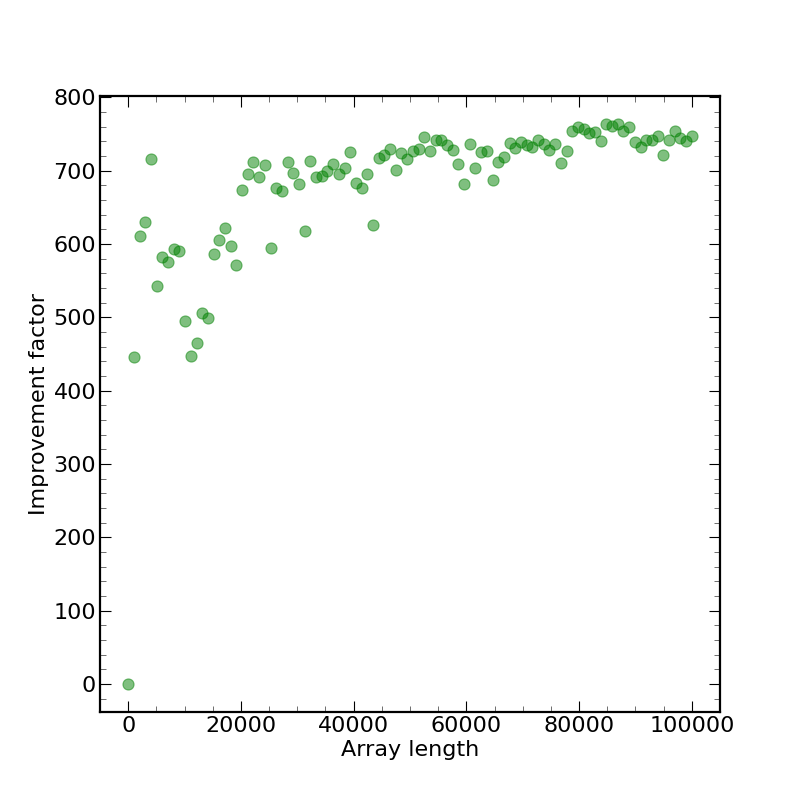

Text(0.5, 0, 'Array length')

In [45]:
fig, ax = subplots()
ax.plot(np.linspace(0, 100*1000, 100),
     python_time/fortran_time,
     'go',
     alpha = 0.5
)
ax.set_ylabel('Improvement factor')
ax.set_xlabel('Array length')